# Siamese Network on template ligand-docking dataset

In [1]:
!nvidia-smi

Wed Feb 23 17:08:05 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.103.01   Driver Version: 470.103.01   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0  On |                  N/A |
|  0%   54C    P8    18W / 240W |    457MiB /  8116MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
#%%capture
#!wget -c https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
#!chmod +x Miniconda3-latest-Linux-x86_64.sh
#!time bash ./Miniconda3-latest-Linux-x86_64.sh -b -f -p /usr/local
#!time conda install -q -y -c conda-forge rdkit

In [3]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [4]:
# Import
import pandas as pd
import numpy as np
from pathlib import Path

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import sys
import os
sys.path.append('/usr/local/lib/python3.7/site-packages/')

In [6]:
dataset = 'oldsmiledata_id_processed_transformed_shuffled'

In [7]:
path = Path('../dataset/oldsmiledata')

In [8]:
list(path.iterdir())

[PosixPath('../dataset/oldsmiledata/test_oldsmiledata_id_processed_transformed_shuffled.csv'),
 PosixPath('../dataset/oldsmiledata/train_balanced_oldsmiledata_id_processed_transformed_shuffled.csv'),
 PosixPath('../dataset/oldsmiledata/oldsmiledata_id_processed_transformed_rescaled_shuffled.csv'),
 PosixPath('../dataset/oldsmiledata/.ipynb_checkpoints'),
 PosixPath('../dataset/oldsmiledata/mol_images'),
 PosixPath('../dataset/oldsmiledata/valid_balanced_oldsmiledata_id_processed_transformed_shuffled.csv'),
 PosixPath('../dataset/oldsmiledata/train_oldsmiledata_id_processed_transformed_shuffled.csv')]

In [9]:
#IMAGES = path/'mol_images'/'all'
train = pd.read_csv(path/f'train_balanced_{dataset}.csv', index_col=0)
valid = pd.read_csv(path/f'valid_balanced_{dataset}.csv', index_col=0)

In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19625 entries, 0 to 19624
Data columns (total 42 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   template                        19625 non-null  object 
 1   docked                          19625 non-null  object 
 2   rmsd                            19625 non-null  float64
 3   uniprot_id                      19625 non-null  object 
 4   smiles_template                 19625 non-null  object 
 5   smiles_docked                   19625 non-null  object 
 6   mcs_smartsString                19625 non-null  object 
 7   template_HeavyAtomCount         19625 non-null  int64  
 8   template_NHOHCount              19625 non-null  int64  
 9   template_NOCount                19625 non-null  int64  
 10  template_RingCount              19625 non-null  int64  
 11  template_NumHAcceptors          19625 non-null  int64  
 12  template_NumHDonors             

In [11]:
valid.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5323 entries, 0 to 5322
Data columns (total 42 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   template                        5323 non-null   object 
 1   docked                          5323 non-null   object 
 2   rmsd                            5323 non-null   float64
 3   uniprot_id                      5323 non-null   object 
 4   smiles_template                 5323 non-null   object 
 5   smiles_docked                   5323 non-null   object 
 6   mcs_smartsString                5323 non-null   object 
 7   template_HeavyAtomCount         5323 non-null   int64  
 8   template_NHOHCount              5323 non-null   int64  
 9   template_NOCount                5323 non-null   int64  
 10  template_RingCount              5323 non-null   int64  
 11  template_NumHAcceptors          5323 non-null   int64  
 12  template_NumHDonors             53

In [12]:
train.head()

,template,docked,rmsd,uniprot_id,smiles_template,smiles_docked,mcs_smartsString,template_HeavyAtomCount,template_NHOHCount,template_NOCount,...,mcs_docked_NumHDonors,mcs_template_NumRotatableBonds,mcs_docked_NumRotatableBonds,ec_tanimoto_similarity,fc_tanimoto_similarity,log_RMSD,bin_RMSD,Xtransf_ec_tanimoto_similarity,Xtransf_fc_tanimoto_similarity,is_valid
0,2JH5_895,1C5O_BAM,3.209,P00734,C[C@@H](C(=O)N1CCOCC1)N1CC[C@H](NS(=O)(=O)/C=C...,NC(=[NH2+])c1ccccc1,"[#7]-[#6]-[#6]:,-[#6]:,-[#6]",28,1,8,...,1,0,1,0.050847,0.059829,1.165959,3,-1.491525,-2.401709,False
1,5Y12_8JX,1TOW_CRZ,1.769,P15090,COc1ccc(S(=O)(=O)NCCCCC(=O)O)c2ccccc12,O=C(O)CCCn1c2ccccc2c2ccccc21,[#6]1:[#6]:[#6]:[#6]:[#6]:[#6]:1:[#6]:[#6]:[#6...,23,2,6,...,0,0,0,0.324561,0.324561,0.570414,1,1.245614,0.245614,False
2,2W26_RIV,2Y80_439,7.217,P00742,O=C(NC[C@H]1CN(c2ccc(N3CCOCC3=O)cc2)C(=O)O1)c1...,CN(C)[C@@H]1CCc2cc(N3CC[C@H](NS(=O)(=O)c4ccc5c...,[#7]-[#6]-[#6]-[#6]-[#7](-[#6]1:[#6]:[#6]:[#6]...,29,1,8,...,1,3,2,0.187166,0.283237,1.976439,3,-0.128342,-0.167630,False
3,1C1U_BAI,2C8W_C7M,4.928,P00734,N=C(N)c1ccc2[nH]c(Cc3nc4ccccc4[nH]3)nc2c1,COc1ccc(S(=O)(=O)NC[C@@H](O)[C@H](Cc2ccccc2)[N...,"[#6]-,:[#6]:[#6]:[#6]:[#6](:,-[#7]:,-[#6]):[#6...",22,5,6,...,0,1,2,0.139037,0.157609,1.594933,3,-0.609626,-1.423913,False
4,5AFY_WCE,3SV2_P05,7.608,P00734,NC(=O)c1cccc(Cl)c1,N[C@H](Cc1ccccc1)C(=O)N1CCC[C@H]1C(=O)NCc1ccncc1,"[#7]-[#6](=[#8])-[#6]:,-[#6]:,-[#6]:[#6]:[#6]:...",10,2,2,...,0,1,4,0.116071,0.157407,2.029200,3,-0.839286,-1.425926,False


# Preprocessing building ImageDataGenerator

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import tensorflow as tf
from pathlib import Path
from tensorflow.keras import applications
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import metrics
from tensorflow.keras import Model
from tensorflow.keras.applications import resnet

### Splitting the data into train and validation sets

In [14]:
train['img_temp'] = train['template'] + '.png'
train['img_docked'] = train['docked'] + '.png'
train['is_valid'] = False
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19625 entries, 0 to 19624
Data columns (total 44 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   template                        19625 non-null  object 
 1   docked                          19625 non-null  object 
 2   rmsd                            19625 non-null  float64
 3   uniprot_id                      19625 non-null  object 
 4   smiles_template                 19625 non-null  object 
 5   smiles_docked                   19625 non-null  object 
 6   mcs_smartsString                19625 non-null  object 
 7   template_HeavyAtomCount         19625 non-null  int64  
 8   template_NHOHCount              19625 non-null  int64  
 9   template_NOCount                19625 non-null  int64  
 10  template_RingCount              19625 non-null  int64  
 11  template_NumHAcceptors          19625 non-null  int64  
 12  template_NumHDonors             

In [15]:
valid['img_temp'] = valid['template'] + '.png'
valid['img_docked'] = valid['docked'] + '.png'
valid['is_valid'] = True
valid.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5323 entries, 0 to 5322
Data columns (total 44 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   template                        5323 non-null   object 
 1   docked                          5323 non-null   object 
 2   rmsd                            5323 non-null   float64
 3   uniprot_id                      5323 non-null   object 
 4   smiles_template                 5323 non-null   object 
 5   smiles_docked                   5323 non-null   object 
 6   mcs_smartsString                5323 non-null   object 
 7   template_HeavyAtomCount         5323 non-null   int64  
 8   template_NHOHCount              5323 non-null   int64  
 9   template_NOCount                5323 non-null   int64  
 10  template_RingCount              5323 non-null   int64  
 11  template_NumHAcceptors          5323 non-null   int64  
 12  template_NumHDonors             53

In [16]:
# image size 600,600
target_shape=(600, 600)

## Creating postive and negative datasets 

In [17]:
train_good = train[train.log_RMSD <= 1.5]
train_good = train_good.reset_index(drop=True)
train_good.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8165 entries, 0 to 8164
Data columns (total 44 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   template                        8165 non-null   object 
 1   docked                          8165 non-null   object 
 2   rmsd                            8165 non-null   float64
 3   uniprot_id                      8165 non-null   object 
 4   smiles_template                 8165 non-null   object 
 5   smiles_docked                   8165 non-null   object 
 6   mcs_smartsString                8165 non-null   object 
 7   template_HeavyAtomCount         8165 non-null   int64  
 8   template_NHOHCount              8165 non-null   int64  
 9   template_NOCount                8165 non-null   int64  
 10  template_RingCount              8165 non-null   int64  
 11  template_NumHAcceptors          8165 non-null   int64  
 12  template_NumHDonors             81

In [18]:
negative = train[train.log_RMSD > 1.5]
negative = negative.reset_index(drop=True)
negative.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11460 entries, 0 to 11459
Data columns (total 44 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   template                        11460 non-null  object 
 1   docked                          11460 non-null  object 
 2   rmsd                            11460 non-null  float64
 3   uniprot_id                      11460 non-null  object 
 4   smiles_template                 11460 non-null  object 
 5   smiles_docked                   11460 non-null  object 
 6   mcs_smartsString                11460 non-null  object 
 7   template_HeavyAtomCount         11460 non-null  int64  
 8   template_NHOHCount              11460 non-null  int64  
 9   template_NOCount                11460 non-null  int64  
 10  template_RingCount              11460 non-null  int64  
 11  template_NumHAcceptors          11460 non-null  int64  
 12  template_NumHDonors             

In [19]:
valid_good = valid[valid.log_RMSD <= 1.5]
valid_good = valid_good.reset_index(drop=True)
valid_good.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2230 entries, 0 to 2229
Data columns (total 44 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   template                        2230 non-null   object 
 1   docked                          2230 non-null   object 
 2   rmsd                            2230 non-null   float64
 3   uniprot_id                      2230 non-null   object 
 4   smiles_template                 2230 non-null   object 
 5   smiles_docked                   2230 non-null   object 
 6   mcs_smartsString                2230 non-null   object 
 7   template_HeavyAtomCount         2230 non-null   int64  
 8   template_NHOHCount              2230 non-null   int64  
 9   template_NOCount                2230 non-null   int64  
 10  template_RingCount              2230 non-null   int64  
 11  template_NumHAcceptors          2230 non-null   int64  
 12  template_NumHDonors             22

In [20]:
val_negative = valid[valid.log_RMSD > 1.5]
val_negative = val_negative.reset_index(drop=True)
val_negative.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3093 entries, 0 to 3092
Data columns (total 44 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   template                        3093 non-null   object 
 1   docked                          3093 non-null   object 
 2   rmsd                            3093 non-null   float64
 3   uniprot_id                      3093 non-null   object 
 4   smiles_template                 3093 non-null   object 
 5   smiles_docked                   3093 non-null   object 
 6   mcs_smartsString                3093 non-null   object 
 7   template_HeavyAtomCount         3093 non-null   int64  
 8   template_NHOHCount              3093 non-null   int64  
 9   template_NOCount                3093 non-null   int64  
 10  template_RingCount              3093 non-null   int64  
 11  template_NumHAcceptors          3093 non-null   int64  
 12  template_NumHDonors             30

In [21]:
negatives = pd.concat((negative ,val_negative), ignore_index=True)
negatives.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14553 entries, 0 to 14552
Data columns (total 44 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   template                        14553 non-null  object 
 1   docked                          14553 non-null  object 
 2   rmsd                            14553 non-null  float64
 3   uniprot_id                      14553 non-null  object 
 4   smiles_template                 14553 non-null  object 
 5   smiles_docked                   14553 non-null  object 
 6   mcs_smartsString                14553 non-null  object 
 7   template_HeavyAtomCount         14553 non-null  int64  
 8   template_NHOHCount              14553 non-null  int64  
 9   template_NOCount                14553 non-null  int64  
 10  template_RingCount              14553 non-null  int64  
 11  template_NumHAcceptors          14553 non-null  int64  
 12  template_NumHDonors             

In [22]:
IMAGES = '../dataset/oldsmiledata/mol_images/poseview_envs/'

In [23]:
def preprocess_image(filename):
    img_str = tf.io.read_file(IMAGES + filename)
    image = tf.image.decode_png(img_str, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, target_shape)
    #image = tf.transpose(image)
    return image

In [24]:
%%capture
#img_shape = preprocess_image(train.img_temp[0]).shape

In [25]:
#img_shape

In [26]:
!nvidia-smi

Wed Feb 23 17:08:09 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.103.01   Driver Version: 470.103.01   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0  On |                  N/A |
|  0%   54C    P8    19W / 240W |    457MiB /  8116MiB |      3%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [27]:
physical_device = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_device[0], True)

In [28]:
def preprocess_triplets(template, docked, negative, rmsd):
    """
    Given the filenames corresponding to the three images, load and
    preprocess them.
    """

    return (preprocess_image(template), preprocess_image(docked), preprocess_image(negative), rmsd)
    

In [29]:
def preprocess_triplets_2(tup, negative):
    """
    Given the filenames corresponding to the three images, load and
    preprocess them.
    """

    return (preprocess_image(tup[0]),
        preprocess_image(tup[1]),
        preprocess_image(negative))

In [30]:
#image = preprocess_image('/4A7I_A7I.png')
#image.shape

In [31]:
train_template_images = [r.img_temp for i, r in train_good.iterrows()]

In [32]:
train_docked_images = [r.img_docked for i, r in train_good.iterrows()]

In [33]:
len(train_template_images), len(train_docked_images)

(8165, 8165)

In [34]:
def find_negative(docked):
    negs = negatives[negatives.docked == docked]
    negs = negs.reset_index(drop=True)
    if len(negs) > 0:
        i = random.randint(0,len(negs) - 1)
        neg = negs.iloc[i]
    else:
        i = random.randint(0,len(negative) - 1)
        neg = negatives.iloc[i]
    return neg.img_docked

In [35]:
n = find_negative(train.iloc[0].docked)
n

'1C5O_BAM.png'

In [36]:
valid_template_images = [r.img_temp for i, r in valid_good.iterrows()]
valid_docked_images = [r.img_docked for i, r in valid_good.iterrows()]

In [37]:
import tensorflow as tf
print('Num GPus avalable: ', len(tf.config.experimental.list_physical_devices('GPU')))

Num GPus avalable:  1


In [38]:
negative_images = [find_negative(r.docked) for i, r in train_good.iterrows()]
np.random.RandomState(seed=32).shuffle(negative_images)

negative_dataset = tf.data.Dataset.from_tensor_slices(negative_images)
negative_dataset = negative_dataset.shuffle(buffer_size=4096)

In [39]:
val_negative_images = [find_negative(r.docked) for i, r in valid_good.iterrows()]
np.random.RandomState(seed=32).shuffle(negative_images)

val_negative_dataset = tf.data.Dataset.from_tensor_slices(negative_images)
val_negative_dataset = negative_dataset.shuffle(buffer_size=4096)

In [40]:
image_count = len(train_template_images) + len(valid_template_images)
image_count

10395

In [41]:
template_dataset = tf.data.Dataset.from_tensor_slices(train_template_images)
docked_dataset = tf.data.Dataset.from_tensor_slices(train_docked_images)

In [42]:
val_template_dataset = tf.data.Dataset.from_tensor_slices(valid_template_images)
val_docked_dataset = tf.data.Dataset.from_tensor_slices(valid_docked_images)

In [43]:
y_train = train_good['log_RMSD']
y_train = tf.data.Dataset.from_tensor_slices(list(y_train))


In [44]:
y_valid = valid_good['log_RMSD']
y_valid = tf.data.Dataset.from_tensor_slices(list(y_train))

In [45]:
log_rmsd = [r.log_RMSD for i, r in train_good.iterrows()]
val_log_rmsd = [r.log_RMSD for i, r in valid_good.iterrows()]

In [46]:
log_rmsd_dataset = tf.data.Dataset.from_tensor_slices(log_rmsd)
val_log_rmsd_dataset = tf.data.Dataset.from_tensor_slices(val_log_rmsd)

In [47]:
!nvidia-smi

Wed Feb 23 17:08:23 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.103.01   Driver Version: 470.103.01   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0  On |                  N/A |
|  0%   57C    P2    52W / 240W |    680MiB /  8116MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Create the train and validation datasets

In [48]:
train_dataset = tf.data.Dataset.zip((template_dataset, docked_dataset, negative_dataset, log_rmsd_dataset)) # template as anchor
#train_dataset = tf.data.Dataset.zip((template_dataset, docked_dataset, negative_dataset)) # template as anchor
valid_dataset = tf.data.Dataset.zip((val_template_dataset, val_docked_dataset, val_negative_dataset, val_log_rmsd_dataset)) # template as anchor
#valid_dataset = tf.data.Dataset.zip((val_template_dataset, val_docked_dataset, val_negative_dataset)) # template as anchor
train_dataset, valid_dataset

(<ZipDataset shapes: ((), (), (), ()), types: (tf.string, tf.string, tf.string, tf.float32)>,
 <ZipDataset shapes: ((), (), (), ()), types: (tf.string, tf.string, tf.string, tf.float32)>)

In [49]:
train_dataset = train_dataset.take(round(image_count * 1))
train_dataset

<TakeDataset shapes: ((), (), (), ()), types: (tf.string, tf.string, tf.string, tf.float32)>

In [50]:
train_dataset = train_dataset.map(preprocess_triplets)
val_dataset = valid_dataset.map(preprocess_triplets)
train_dataset, val_dataset

(<MapDataset shapes: ((600, 600, 3), (600, 600, 3), (600, 600, 3), ()), types: (tf.float32, tf.float32, tf.float32, tf.float32)>,
 <MapDataset shapes: ((600, 600, 3), (600, 600, 3), (600, 600, 3), ()), types: (tf.float32, tf.float32, tf.float32, tf.float32)>)

In [51]:
train_dl = train_dataset.batch(8, drop_remainder=True)
train_dl = train_dl.prefetch(8)
train_dl

<PrefetchDataset shapes: ((8, 600, 600, 3), (8, 600, 600, 3), (8, 600, 600, 3), (8,)), types: (tf.float32, tf.float32, tf.float32, tf.float32)>

In [52]:
val_dl = val_dataset.batch(8, drop_remainder=True)
val_dl = val_dl.prefetch(8)
val_dl

<PrefetchDataset shapes: ((8, 600, 600, 3), (8, 600, 600, 3), (8, 600, 600, 3), (8,)), types: (tf.float32, tf.float32, tf.float32, tf.float32)>

## Anchor, positive and the distance between them computed by the distance layer

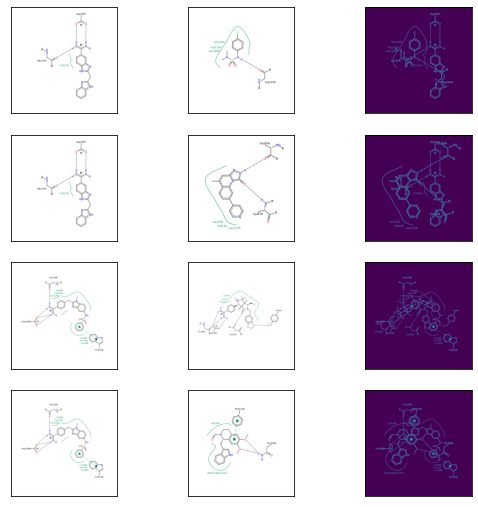

In [53]:
def visualize(anchor, positive, negative, rmsd):
    """Visualize a few triplets from the supplied batches."""

    def show(ax, image):
        ax.imshow(image)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    

    fig = plt.figure(figsize=(9, 9))

    axs = fig.subplots(4, 3)
    for i in range(0, 4, 2):
        show(axs[i, 0], anchor[i])
        show(axs[i + 1, 0], anchor[i])
        show(axs[i, 1], positive[i])
        show(axs[i + 1, 1], negative[i])
        ap_distance = tf.reduce_sum(tf.square(anchor[i] - positive[i]), -1)
        an_distance = tf.reduce_sum(tf.square(anchor[i] - negative[i]), -1)
        show(axs[i, 2], ap_distance)
        show(axs[i + 1, 2], an_distance)
        loss = ap_distance - an_distance
        loss = tf.maximum(loss, 0.0)
    


visualize(*list(val_dl.take(1).as_numpy_iterator())[0])

## Visualization of Anchor, Positive and the Negative image

1.3719418
1.3045418
1.3134549


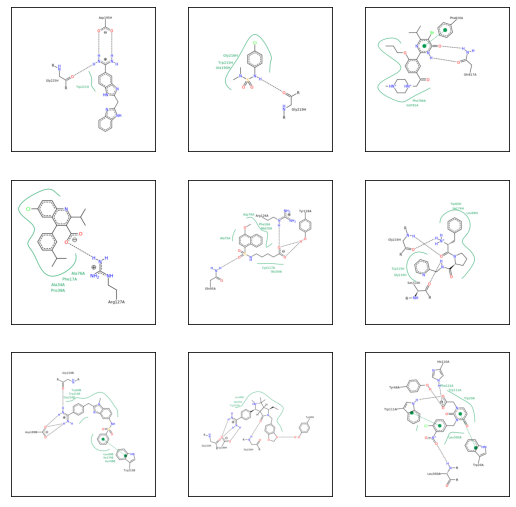

In [54]:
def visualize2(anchor, positive, negative, rmsd):
    """Visualize a few triplets from the supplied batches."""

    def show(ax, image):
        ax.imshow(image)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    fig = plt.figure(figsize=(9, 9))

    axs = fig.subplots(3, 3)
    for i in range(3):
        print(rmsd[i])
        show(axs[i, 0], anchor[i])
        show(axs[i, 1], positive[i])
        show(axs[i, 2], negative[i])


visualize2(*list(val_dl.take(1).as_numpy_iterator())[0])

In [55]:
def visualize_positive(anchor, positive):
    """Visualize a few triplets from the supplied batches."""

    def show(ax, image):
        ax.imshow(image)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    fig = plt.figure(figsize=(1, 2))

    axs = fig.subplots(1, 2)
    show(axs[0, 0], anchor)
    show(axs[0, 1], positive)

# Siamese network with distance layer and RMSD as adaptive margin in loss function

### Use RMSD as an adaptive margin in loss function

In [56]:
base_cnn = resnet.ResNet50(
    weights="imagenet", input_shape=target_shape +  (3,), include_top=False
)

flatten = layers.Flatten()(base_cnn.output)
dense1 = layers.Dense(256, activation="relu")(flatten)
dense1 = layers.BatchNormalization()(dense1)
dense2 = layers.Dense(128, activation="relu")(dense1)
dense2 = layers.BatchNormalization()(dense2)
output = layers.Dense(128)(dense2)

embedding = Model(base_cnn.input, output, name="Embedding")

trainable = False
for layer in base_cnn.layers:
    if layer.name == "conv5_block1_out":
        trainable = True
    layer.trainable = trainable


In [57]:
!nvidia-smi

Wed Feb 23 17:08:27 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.103.01   Driver Version: 470.103.01   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0  On |                  N/A |
|  0%   58C    P2    52W / 240W |   4904MiB /  8116MiB |     20%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [58]:
class DistanceLayer(layers.Layer):
    """
    This layer is responsible for computing the distance between the anchor
    embedding and the positive embedding, and the anchor embedding and the
    negative embedding.
    """

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative, rmsd):
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
        return (ap_distance, an_distance, rmsd)


anchor_input = layers.Input(name="anchor", shape=target_shape + (3,))
positive_input = layers.Input(name="positive", shape=target_shape + (3,))
negative_input = layers.Input(name="negative", shape=target_shape + (3,))
rmsd_input = layers.Input(name='rmsd', shape=(1))

distances = DistanceLayer()(
    embedding(resnet.preprocess_input(anchor_input)),
    embedding(resnet.preprocess_input(positive_input)),
    embedding(resnet.preprocess_input(negative_input)),
    rmsd_input,
)

siamese_network = Model(
    inputs=[anchor_input, positive_input, negative_input, rmsd_input], outputs=distances
)

siamese_network.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
anchor (InputLayer)             [(None, 600, 600, 3) 0                                            
__________________________________________________________________________________________________
positive (InputLayer)           [(None, 600, 600, 3) 0                                            
__________________________________________________________________________________________________
negative (InputLayer)           [(None, 600, 600, 3) 0                                            
__________________________________________________________________________________________________
tf.__operators__.getitem (Slici (None, 600, 600, 3)  0           anchor[0][0]                     
______________________________________________________________________________________________

### Triplet loss defined as: 

$$\displaystyle {\mathcal {L}}\left(A,P,N\right)=\operatorname {max} \left({\|\operatorname {f} \left(A\right)-\operatorname {f} \left(P\right)\|}^{2}-{\|\operatorname {f} \left(A\right)-\operatorname {f} \left(N\right)\|}^{2}+\alpha ,0\right)$$

In [59]:
class SiameseModel(Model):
    """The Siamese Network model with a custom training and testing loops.

    Computes the triplet loss using the three embeddings produced by the
    Siamese Network.

    The triplet loss is defined as:
       L(A, P, N) = max(‖f(A) - f(P)‖² - ‖f(A) - f(N)‖² + margin, 0)
    """

    def __init__(self, siamese_network, margin=2):
        super(SiameseModel, self).__init__()
        self.siamese_network = siamese_network
        self.margin = margin
        self.loss_tracker = metrics.Mean(name="loss")
        self.rmse_tracker = metrics.RootMeanSquaredError(name="rmse")

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        # GradientTape is a context manager that records every operation that
        # you do inside. We are using it here to compute the loss so we can get
        # the gradients and apply them using the optimizer specified in
        # `compile()`.
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)

        # Storing the gradients of the loss function with respect to the
        # weights/parameters.
        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)

        # Applying the gradients on the model using the specified optimizer
        self.optimizer.apply_gradients(
            zip(gradients, self.siamese_network.trainable_weights)
        )

        # Let's update and return the training loss metric.
        self.loss_tracker.update_state(loss)
        
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)
        ap_distance, an_distance, rmsd = self.siamese_network(data)
        # Let's update and return the loss metric and rmse metric.
        self.loss_tracker.update_state(loss)
        distance = ap_distance - an_distance
        # RMSE (Euclidean distance) between anchor and positive image minus RMSD
        rmse = tf.maximum(distance, 0.0)
        self.rmse_tracker.update_state(0.0, rmse)
        return {"loss": self.loss_tracker.result(), 'rmse': self.rmse_tracker.result()}

    def _compute_loss(self, data):
        # The output of the network is a tuple containing the distances
        # between the anchor and the positive example, and the anchor and
        # the negative example.
        ap_distance, an_distance, rmsd = self.siamese_network(data)

        # Computing the Triplet Loss by subtracting both distances and
        # making sure we don't get a negative value.
        loss = ap_distance - an_distance
        loss = tf.maximum(loss + self.margin - rmsd, 0.0)
        return loss

    @property
    def metrics(self):
        # We need to list our metrics here so the `reset_states()` can be
        # called automatically.
        return [self.loss_tracker, self.rmse_tracker]


### Choose optimizer and train model

In [60]:
physical_device = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_device[0], True)
print("GPUS available", len(physical_device))

GPUS available 1


In [61]:
siamese_model = SiameseModel(siamese_network)
siamese_model.compile(optimizer=optimizers.Adam(0.0001), metrics=metrics.RootMeanSquaredError(name='rmse'))

In [62]:
!nvidia-smi

Wed Feb 23 17:08:28 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.103.01   Driver Version: 470.103.01   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0  On |                  N/A |
|  0%   58C    P2    52W / 240W |   4908MiB /  8116MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
model = siamese_model.fit(train_dl, validation_data=val_dl, epochs=10) # save

Epoch 1/10


### RMSE as difference between rmsd and ap - an distances

In [ ]:
model = siamese_model.fit(train_dl, validation_data=val_dl, epochs=10)

In [ ]:
plt.plot(model.history['loss'])
plt.plot(model.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Inspecting what the network has learned

In [ ]:
sample = next(iter(val_dl))
visualize2(*sample)

anchor, positive, negative, _ = sample
anchor_embedding, positive_embedding, negative_embedding = (
    embedding(resnet.preprocess_input(anchor)),
    embedding(resnet.preprocess_input(positive)),
    embedding(resnet.preprocess_input(negative)),
)

In [ ]:
cosine_similarity = metrics.CosineSimilarity()

positive_similarity = cosine_similarity(anchor_embedding, positive_embedding)
print("Positive similarity:", positive_similarity.numpy())

negative_similarity = cosine_similarity(anchor_embedding, negative_embedding)
print("Negative similarity", negative_similarity.numpy())


In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import os, sys, cv2, matplotlib.pyplot as plt, numpy as np, pickle
#import sklearn, pandas as pd, seaborn as sn
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras import backend as K
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings('ignore')

# Load models
#model = embedding
model = siamese_model

names = next(iter(val_dl))

anchor, positive, negative, rmsd = names
anchor = tf.reshape(anchor[0], (1, 224, 224, 3))
positive = tf.reshape(positive[0], (1, 224, 224, 3))
negative = tf.reshape(negative[0], (1, 224, 224, 3))
rmsd = tf.reshape(rmsd[0], (1, 1))


test_im = []
test_im.append(anchor)
test_im.append(positive)
test_im.append(negative)

print(test_im[0].shape)
_, r,c,_ = test_im[0].shape
print(test_im[0].shape)
test_im = np.array(test_im)
test_im = test_im.reshape((len(test_im), r,c,3))

test_im = 1 - test_im/255

# Predict
pred = model.predict([anchor, positive, negative, rmsd])

print(pred)

num = int(pred.shape[0]/3)
colors = ['red', 'blue', 'green'] # set colors of target labels

# Set target labels
y = [colors[0] for i in range(num)]
y += [colors[1] for i in range(num)]
y += [colors[2] for i in range(num)]

feat1 = pred[:,0]
feat2 = pred[:,1]
feat3 = pred[:,2]

# Plot 3d scatter plot
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(feat1, feat2, feat3, c=y, marker='.')
plt.show()

# Parameter optimization 

In [ ]:
def create_embedding(dropout = None):
    base_cnn = resnet.ResNet50(
        weights="imagenet", input_shape=target_shape +  (3,), include_top=False
    )

    flatten = layers.Flatten()(base_cnn.output)
    dense1 = layers.Dense(512, activation="relu")(flatten)
    dense1 = layers.BatchNormalization()(dense1)
    if dropout != None: 
        layer = layers.Dropout(dropout)
    dense2 = layers.Dense(256, activation="relu")(dense1)
    dense2 = layers.BatchNormalization()(dense2)
    output = layers.Dense(256)(dense2)

    embedding = Model(base_cnn.input, output, name="Embedding")

    trainable = False
    for layer in base_cnn.layers:
        if layer.name == "conv5_block1_out":
            trainable = True
        layer.trainable = trainable
    return embedding

In [ ]:
def create_siamese_net(embedding):
    anchor_input = layers.Input(name="anchor", shape=target_shape + (3,))
    positive_input = layers.Input(name="positive", shape=target_shape + (3,))
    negative_input = layers.Input(name="negative", shape=target_shape + (3,))

    distances = DistanceLayer()(
        embedding(resnet.preprocess_input(anchor_input)),
        embedding(resnet.preprocess_input(positive_input)),
        embedding(resnet.preprocess_input(negative_input)),
    )

    siamese_network = Model(
        inputs=[anchor_input, positive_input, negative_input], outputs=distances
    )

    return siamese_network

In [ ]:
def train_model(epochs = 5, lr=0.0001, dropout=None, verbose=False):
    embedding = create_embedding(dropout=dropout)
    siamese_network = create_siamese_net(embedding)
    siamese_model = SiameseModel(siamese_network)
    siamese_model.compile(optimizer=optimizers.Adam(learning_rate=lr), metrics=[metrics.RootMeanSquaredError(name='rmse')])
    model = siamese_model.fit(train_dl, validation_data=val_dl, epochs=epochs)
    if verbose:
        plt.plot(model.history['loss'])
        plt.plot(model.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper left')
        plt.show()
        plt.plot(model.history['val_rmse'])
        plt.title('model RMSE')
        plt.ylabel('RMSE')
        plt.xlabel('epoch')
        plt.legend(['rmse'], loc='upper left')
        plt.show()
    return siamese_model
        
    

# Save the model

In [ ]:
from tensorflow.keras import models

In [ ]:
model.compute_output_shape(input_shape= [(None, 600, 600, 3), (None, 600, 600, 3), (None, 600, 600, 3), (None, 1)])                        

In [ ]:
model.save('models/siamese_model_envs.h5')

In [ ]:
model = models.load_model('models/siamese_model')

# Test the model performance on instances

In [ ]:
sample = next(iter(val_dl))

In [ ]:
docked_sample = valid.iloc[0]
docked_sample.docked

In [ ]:
docked_image = preprocess_image(docked_sample.img_docked)

### Sort the templates for one docked molecule by order of lowest rmsd

In [ ]:
templates = valid[valid.docked == docked_sample.docked]
templates = templates.reset_index()
templates = templates.sort_values(by=['rmsd'], ignore_index=True)
templates

In [ ]:
template_image = preprocess_image(templates.iloc[0].img_temp)

In [ ]:
print('Show docked molecule')
plt.imshow(docked_image)

In [ ]:
print('Show lowest rmsd template molecule')
plt.imshow(template_image)

In [ ]:
rmsds = templates.log_RMSD
rmsds

In [ ]:
# Root Mean Squared Error
rmse = metrics.RootMeanSquaredError()

In [ ]:
# Similarity search
similarity = metrics.CosineSimilarity()

In [ ]:
tf_template = tf.reshape(template_image, (1,600,600,3))

In [ ]:
tf_docked = tf.reshape(docked_image, (1,600,600,3))

In [ ]:
template_embedding, docked_embedding = (
    embedding(resnet.preprocess_input(tf_template)),
    embedding(resnet.preprocess_input(tf_docked)),
)

In [ ]:
rmse_positive = rmse(template_embedding, docked_embedding)
rmse_positive.numpy(), templates.iloc[0].log_RMSD

In [ ]:
type(rmse_positive.numpy())

In [ ]:
def get_rmse(row):
    # Checks the embedding space for two inputs and return the rmse
    docked_image = preprocess_image(row.img_docked)
    template_image = preprocess_image(row.img_temp)
    template_image = tf.reshape(template_image, (1,600,600,3))
    docked_image = tf.reshape(docked_image, (1,600,600,3))
    template_embedding, docked_embedding = (
        embedding(resnet.preprocess_input(template_image)),
        embedding(resnet.preprocess_input(docked_image)),
    )
    rmse_positive = rmse(template_embedding, docked_embedding)
    return rmse_positive.numpy()

### Order ranked by rmse

In [ ]:
rmses = {}
for i, r in templates.iterrows(): 
    rm = get_rmse(r)
    rmses[i] = rm
rmses

### Order according to the model

In [ ]:
rmses_sorted = sorted(rmses, key=rmses.get)
rmses_sorted

In [ ]:
min(rmses.values())

In [ ]:
from scipy.stats import pearsonr

In [ ]:
df1 = pd.DataFrame(rmsds)
df1

In [ ]:
df2 = pd.DataFrame.from_dict(rmses, orient='index')
df2 = df2.rename(columns={0:'rmse'})
df2

In [ ]:
df_full = pd.concat([df1, df2], axis=1 , ignore_index=False)
df_full

### Correlation values

In [ ]:
full_correlation = pearsonr(df_full['rmse'], df_full['log_RMSD'])
print('Correlation coeffiecient', full_correlation[0])
print('P-value: ', full_correlation[1])

### Scatter plot